In [1]:
from scripts.utils import Dataset, prepare_data_from_dataframe

In [2]:
data = Dataset('spider/train_spider.json', 'spider/tables.json')
data.gen_dataframe(transform=True)

,NL_query,SQL_query,SQLtable
0,How many heads of the departments are older th...,SELECT count(*) FROM head WHERE age > 5 6,department_management
1,"List the name, born state and age of the heads...","SELECT name , born_state , age FROM head ORDER...",department_management
2,"List the creation year, name and budget of eac...","SELECT creation , name , budget_in_billions FR...",department_management
3,What are the maximum and minimum budget of the...,"SELECT max(budget_in_billions) , min(budget_in...",department_management
4,What is the average number of employees of the...,SELECT avg(num_employees) FROM department WHER...,department_management
...,...,...,...
6995,What are all the company names that have a boo...,SELECT T1.company_name FROM culture_company AS...,culture_company
6996,Show the movie titles and book titles for all ...,"SELECT T1.title , T3.book_title FROM movie AS ...",culture_company
6997,What are the titles of movies and books corres...,"SELECT T1.title , T3.book_title FROM movie AS ...",culture_company
6998,Show all company names with a movie directed i...,SELECT T2.company_name FROM movie AS T1 JOIN c...,culture_company


In [3]:
MAX_LENGTH = 40

input_corpus, output_corpus, pairs = prepare_data_from_dataframe(data, MAX_LENGTH)

Input corpus with 4470 words
Output corpus with 3380 words


In [4]:
'%d pairs'%(len(pairs))

'6259 pairs'

In [5]:
pairs[4]

['what is the average number of employees of the departments whose rank is between 1 0 and 1 5 ? | departmentmanagement numemployees headid bornstate departmentid creation',
 'select avg numemployees from department where ranking between 1 0 and 1 5']

In [9]:
import torch

from scripts.seq2seq import EncoderRNN, DecoderRNN

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
hidden_size = 256
encoder = EncoderRNN(input_corpus.NWords, hidden_size, device).to(device)
decoder = DecoderRNN(hidden_size, output_corpus.NWords, device, dropout_p=0.1, max_length=MAX_LENGTH).to(device)

In [11]:
from scripts.train_test import Processor

In [12]:
processor = Processor(encoder=encoder, decoder=decoder, pairs=pairs, device=device, maxlen=MAX_LENGTH)

In [13]:
losses = processor.train(75000, input_corpus=input_corpus, output_corpus=output_corpus,
                         print_every=5000, plot_every=100, learnig_rate=0.01)

3m 41s (- 51m 43s) (5000 6%) 3.8996
7m 13s (- 46m 55s) (10000 13%) 3.0553
10m 44s (- 42m 57s) (15000 20%) 2.8131
14m 21s (- 39m 29s) (20000 26%) 2.7290
17m 59s (- 35m 59s) (25000 33%) 2.6537
21m 36s (- 32m 24s) (30000 40%) 2.6418
25m 13s (- 28m 49s) (35000 46%) 2.6010
28m 48s (- 25m 12s) (40000 53%) 2.5245
32m 24s (- 21m 36s) (45000 60%) 2.3857
35m 59s (- 17m 59s) (50000 66%) 2.3345
39m 35s (- 14m 23s) (55000 73%) 2.2460
43m 9s (- 10m 47s) (60000 80%) 2.1925
46m 47s (- 7m 11s) (65000 86%) 2.1219
50m 39s (- 3m 37s) (70000 93%) 2.0550
54m 23s (- 0m 0s) (75000 100%) 1.9618


In [14]:
torch.save({'encoder':encoder.state_dict(), 'decoder':decoder.state_dict()}, 'checkpoints/seq2sql_75m.pth')

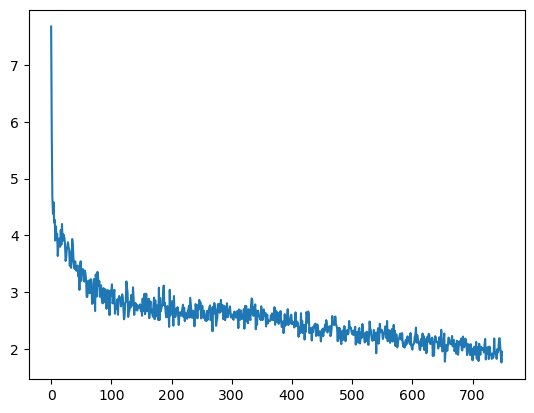

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(len(losses)),losses)

In [18]:
processor.evaluateRandomly(input_corpus=input_corpus, output_corpus=output_corpus)

IN: which wineries produce at least four wines ? | wine1 year area cases winery price
TG: select winery from wine group by winery having count all greaterthanequalto 4
PD: select name from from from where where equalto t1 <EOS>

IN: show company name and main industry without a gas station . | gascompany mainindustry companyid location stationid company
TG: select company mainindustry from company where companyid not in select companyid from stationcompany 
PD: select name location from from where where equalto in <EOS>

IN: what are the names of all the races that occurred in the year 2 0 1 7 ? | formula1 altitude year time name date
TG: select name from races where year equalto 2 0 1 7
PD: select name from from where where equalto 1 1 1 1 1 <EOS>

IN: what are the names of all colleges that have two or more players ? | matchseason college totalwl team player name
TG: select college from matchseason group by college having count all greaterthanequalto 2
PD: select name from player whe